In [161]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display, display_rows, sample_batch, normalize_image_data, denormalize_image_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
USE_GPU = True
TRAIN = True

In [163]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724280303.231911  107476 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724280303.233513  107476 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724280303.235386  107476 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724280303.236587  107476 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [274]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.002
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [275]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 29, 24), (2740,), (2740, 32, 32, 1))

In [276]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(32, 32, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_253 (Conv2D)             │ (None, 16, 16, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_255 (LeakyReLU)     │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_254 (Conv2D)             │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_256 (LeakyReLU)     │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_255 (Conv2D)             │ (None, 4, 4, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_257 (LeakyReLU)     │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_256 (Conv2D)             │ (None, 2, 2, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_258 (LeakyReLU)     │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_257 (Conv2D)             │ (None, 2, 2, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_259 (LeakyReLU)     │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_258 (Conv2D)             │ (None, 1, 1, 1)        │         2,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,489 (2.67 MB)

 Trainable params: 699,489 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=4, strides=2, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_28 (Reshape)            │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_143            │ (None, 4, 4, 256)      │     4,194,304 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_259 (Conv2D)             │ (None, 4, 4, 256)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_260 (LeakyReLU)     │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_260 (Conv2D)             │ (None, 4, 4, 128)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_261 (LeakyReLU)     │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_144            │ (None, 8, 8, 64)       │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_262 (LeakyReLU)     │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_145            │ (None, 16, 16, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_261 (Conv2D)             │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_263 (LeakyReLU)     │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_146            │ (None, 16, 16, 32)     │        16,384 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_262 (Conv2D)             │ (None, 16, 16, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 5,280,001 (20.14 MB)

 Trainable params: 5,279,105 (20.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [278]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [279]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [280]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/55


2024-08-22 00:05:44.488763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_fusion', 16 bytes spill stores, 16 bytes spill loads



2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - c_gp: 0.3563 - c_loss: -1.0188 - c_wass_loss: -4.5815 - g_loss: 8.9118

2024-08-22 00:06:03.755824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_fusion', 16 bytes spill stores, 16 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - c_gp: 0.4663 - c_loss: -3.6046 - c_wass_loss: -8.2681 - g_loss: 11.7640 

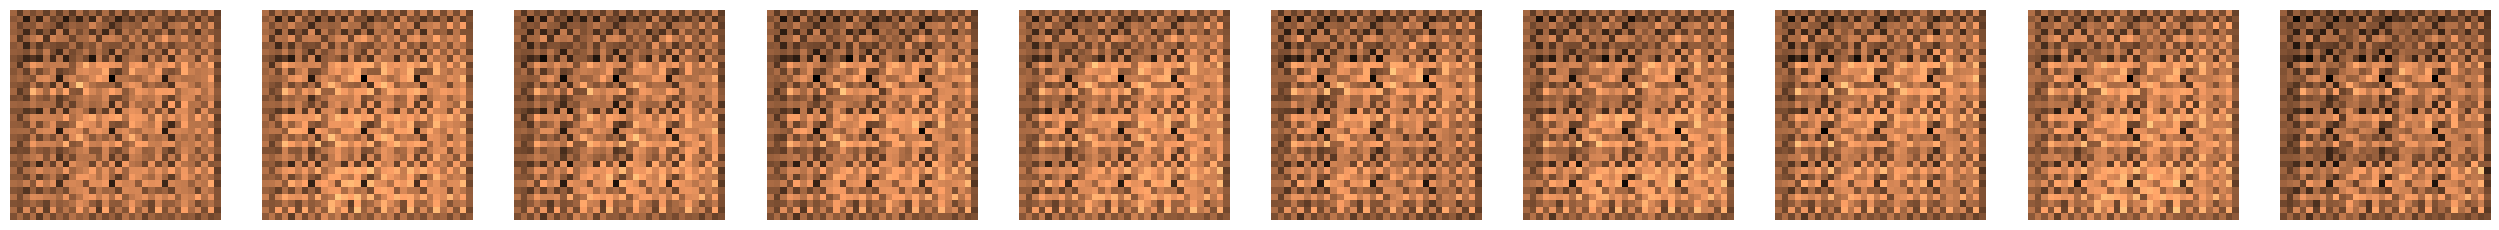

3/3 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - c_gp: 0.5214 - c_loss: -4.8976 - c_wass_loss: -10.1114 - g_loss: 13.1901
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - c_gp: 0.7593 - c_loss: -19.4178 - c_wass_loss: -27.0106 - g_loss: 38.1556

2024-08-22 00:06:04.355893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10876461741428177913


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.5293 - c_loss: -17.6847 - c_wass_loss: -22.9780 - g_loss: 36.1720
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - c_gp: 0.5578 - c_loss: -15.8835 - c_wass_loss: -21.4620 - g_loss: 22.0165

2024-08-22 00:06:04.745814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10876461741428177913


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.5401 - c_loss: -15.0297 - c_wass_loss: -20.4304 - g_loss: 20.1142
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.5244 - c_loss: -12.3407 - c_wass_loss: -17.5849 - g_loss: 12.2567
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - c_gp: 0.7917 - c_loss: -10.2048 - c_wass_loss: -18.1215 - g_loss: 8.2727

2024-08-22 00:06:05.504066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10876461741428177913


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.7115 - c_loss: -9.5453 - c_wass_loss: -16.6603 - g_loss: 6.8081
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - c_gp: 0.2754 - c_loss: -8.5160 - c_wass_loss: -11.2695 - g_loss: 6.1929

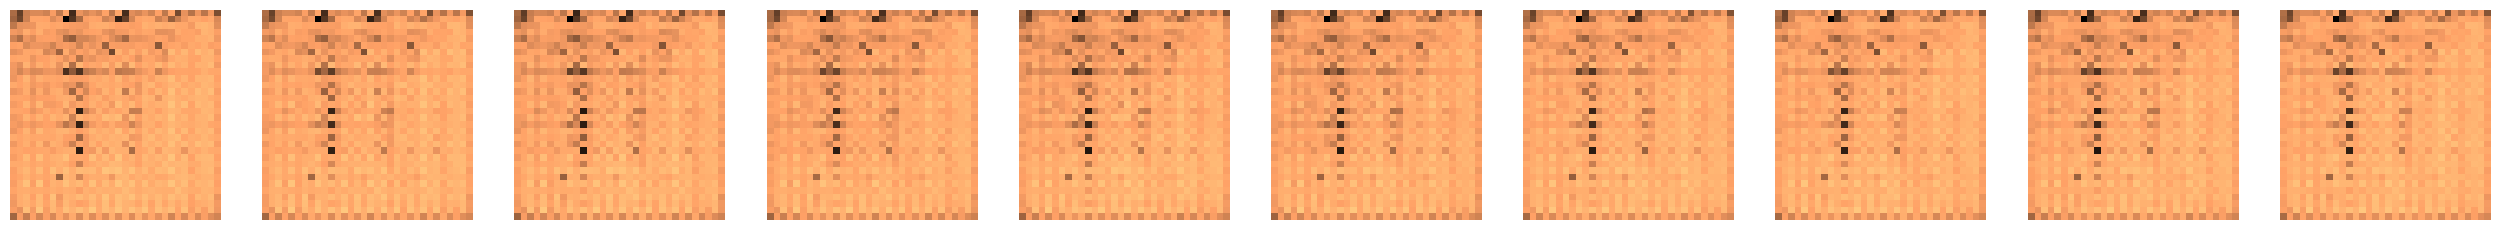

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - c_gp: 0.2599 - c_loss: -8.4371 - c_wass_loss: -11.0358 - g_loss: 6.2227
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - c_gp: 0.1617 - c_loss: -7.5238 - c_wass_loss: -9.1406 - g_loss: 8.9712

2024-08-22 00:06:06.376835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10876461741428177913


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1707 - c_loss: -7.2363 - c_wass_loss: -8.9432 - g_loss: 8.7925
Epoch 14/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1487 - c_loss: -5.9455 - c_wass_loss: -7.4323 - g_loss: 3.1781
Epoch 16/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1243 - c_loss: -5.1784 - c_wass_loss: -6.4216 - g_loss: 4.2835
Epoch 18/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1230 - c_loss: -4.5004 - c_wass_loss: -5.7303 - g_loss: 4.1347
Epoch 20/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss

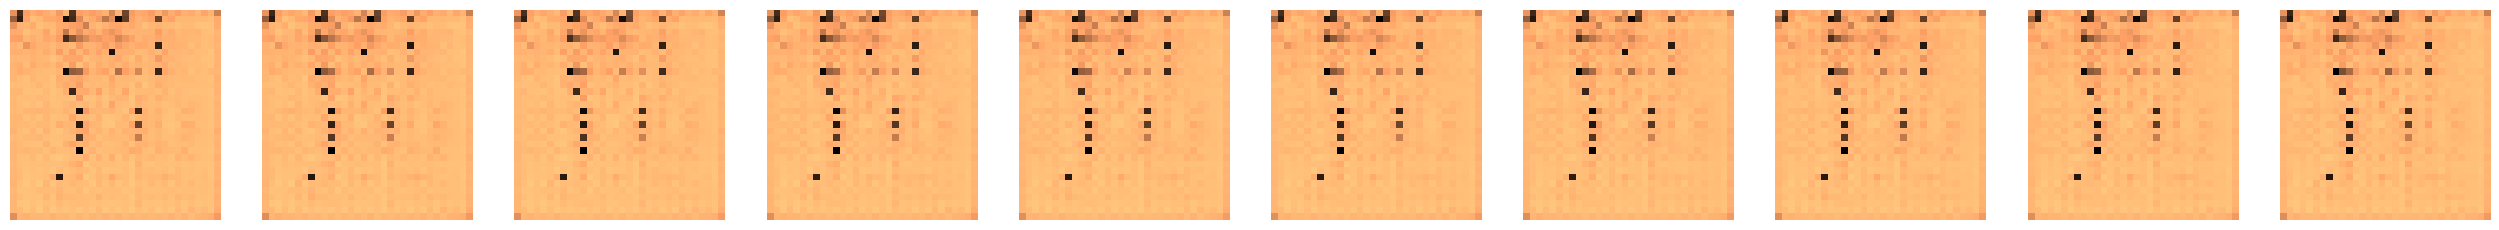

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - c_gp: 0.0520 - c_loss: -3.9370 - c_wass_loss: -4.4565 - g_loss: 3.6723
Epoch 22/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0850 - c_loss: -3.6910 - c_wass_loss: -4.5409 - g_loss: 2.2587
Epoch 24/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0350 - c_loss: -3.4220 - c_wass_loss: -3.7720 - g_loss: 1.9763
Epoch 26/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0514 - c_loss: -3.2929 - c_wass_loss: -3.8068 - g_loss: 2.9270
Epoch 28/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss

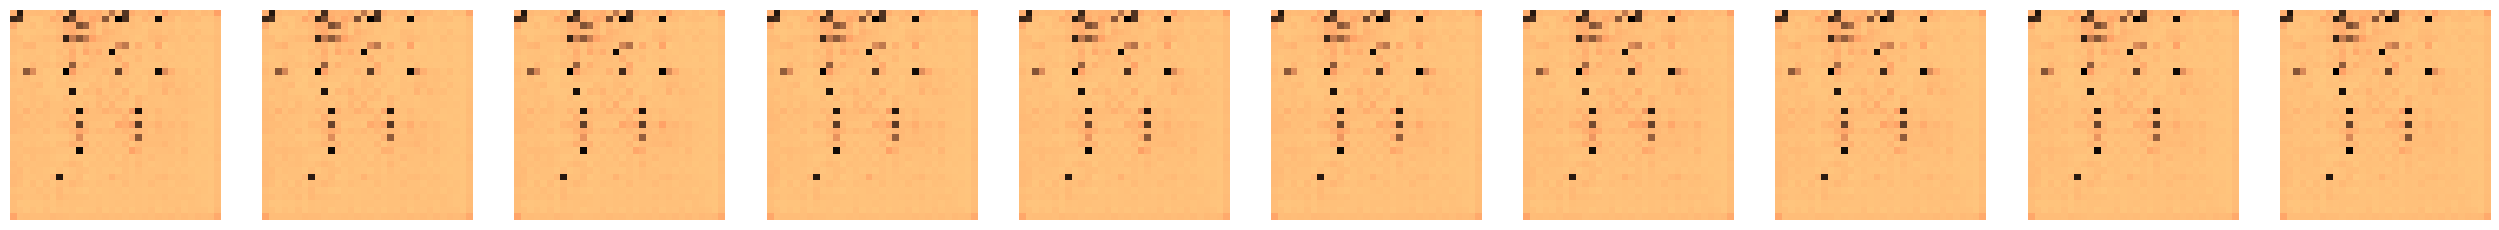

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - c_gp: 0.0585 - c_loss: -2.7420 - c_wass_loss: -3.3270 - g_loss: 5.2370
Epoch 32/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0500 - c_loss: -2.6903 - c_wass_loss: -3.1905 - g_loss: 1.8862
Epoch 34/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0588 - c_loss: -2.5394 - c_wass_loss: -3.1279 - g_loss: 0.8755
Epoch 36/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0560 - c_loss: -2.4884 - c_wass_loss: -3.0481 - g_loss: 1.6466
Epoch 38/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss

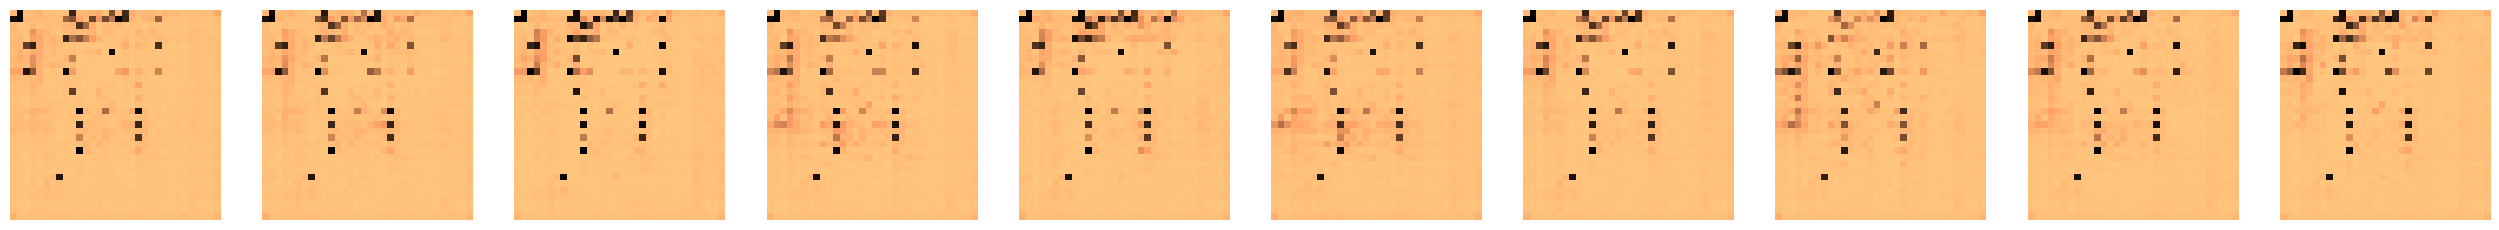

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - c_gp: 0.0603 - c_loss: -2.3699 - c_wass_loss: -2.9727 - g_loss: 2.2793
Epoch 42/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0218 - c_loss: -2.0549 - c_wass_loss: -2.2725 - g_loss: 7.5567
Epoch 44/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0364 - c_loss: -2.3018 - c_wass_loss: -2.6657 - g_loss: 4.8635
Epoch 46/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0339 - c_loss: -1.8108 - c_wass_loss: -2.1503 - g_loss: 1.5220
Epoch 48/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 

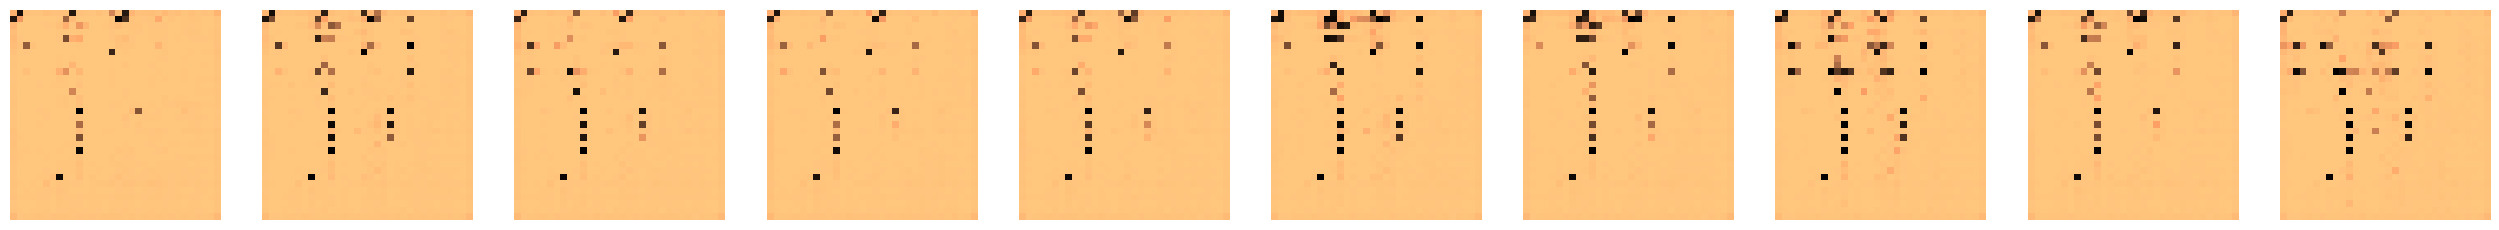

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - c_gp: 0.0206 - c_loss: -1.1540 - c_wass_loss: -1.3599 - g_loss: 1.3400
Epoch 52/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - c_gp: 0.0141 - c_loss: -0.9001 - c_wass_loss: -1.0411 - g_loss: 3.9745

2024-08-22 00:06:14.448467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10876461741428177913


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0305 - c_loss: -0.9698 - c_wass_loss: -1.2752 - g_loss: 4.1350
Epoch 54/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.0183 - c_loss: -1.1455 - c_wass_loss: -1.3288 - g_loss: -0.2745


In [281]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


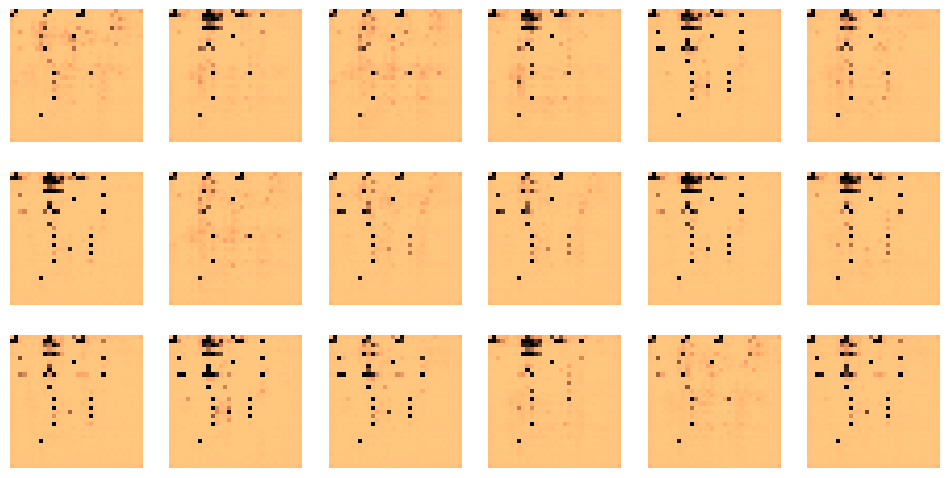

In [282]:
if TRAIN:
    
    noise = np.random.normal(size=(18, 1024))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/language_phonemes_all.npz",
        generated_languages=generated_languages,
    )

    display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

else:
    data = np.load("./data/language_phonemes_all.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

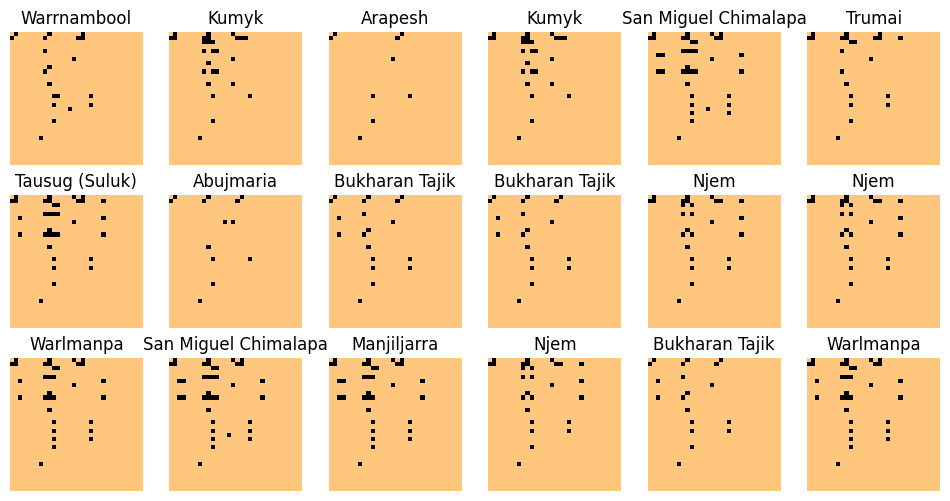

In [283]:
import numpy as np
import matplotlib.pyplot as plt

#all_data = np.squeeze(X)

def get_closest_matches(train, generated, n=12):
    closest = np.zeros(shape=(n, *generated.shape[1:]))
    closest_idx = np.zeros(shape=(n)).astype(int)

    cnt = 0
    for _ in range(n):
        c_diff = 99999
        for sample_idx, sample in enumerate(train):
            diff = np.mean(np.abs(generated[cnt] - sample))
            if diff < c_diff:
                closest_idx[cnt] = sample_idx
                closest[cnt] = sample.copy()
                c_diff = diff
        cnt += 1
    return closest_idx, closest

closest_idx, closest = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))